In [ ]:
# Cell 1: ติดตั้ง packages ที่ต้องใช้
!pip install --upgrade pip
!pip install numpy
!pip install faiss-cpu
!pip install sentence-transformers
!pip install torch --upgrade
!pip install transformers
!pip install accelerate
!pip install gradio
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 131.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 60.6 MB/s  0:00:01


In [ ]:
# Cell 2: โหลด KB ใหม่ (ต้องเป็น text ของโรคเบาหวานจริง)
# ตัวอย่าง: ไฟล์ JSON หรือ .npy ที่มี list ของ dict {'url':..., 'text':...}
import numpy as np
import json

# ตัวอย่างถ้าไฟล์ .npy
kb_data = np.load('/content/cleaned_diabetes_data.npy', allow_pickle=True)
print(f"จำนวนเอกสารใน KB: {len(kb_data)}")
print("ตัวอย่างเอกสาร:", kb_data[0])

จำนวนเอกสารใน KB: 500
ตัวอย่างเอกสาร: {'url': 'https://diabetes.org/about-diabetes', 'text': "Change Site Language: (en) (es) keywords Search Open main menu bold Learn your risk for type 2 and take steps to prevent it Learn the ins and outs of diabetes and steps for better care Obesity care is as unique as you are. Discover the different treatment and prevention options. bold bold Learn what you can do to keep your child with diabetes safe at school What you need to know about gestational diabetes Make a plan to be prepared when illness strikes bold bold bold Sign up to receive timely information on topics to help you and your family live a healthy life Bringing ADA's evidence-based guidelines and perspective directly to you in the store so you can make informed choices. bold bold bold bold bold bold bold Take the 60-second test to find out your risk Find help and resources in your zip code bold bold bold bold Choose between a one-time donation or recurring monthly gifts. Reach out and

In [ ]:
# Cell 3: Clean text และ chunk ให้เหมาะสม
# ขนาด chunk = 150 words, overlap = 30 words

def chunk_text(text, max_words=150, overlap=30):
    if not text:
        return []
    words = text.split()
    if len(words) == 0:
        return []
    chunks = []
    start = 0
    while start < len(words):
        end = start + max_words
        chunk = " ".join(words[start:end]).strip()
        if chunk.lower() != "reserved." and chunk != "":
            chunks.append(chunk)
        start += max_words - overlap
    return chunks

kb_chunks = []
for item in kb_data:
    text = item.get("text") if isinstance(item, dict) else str(item)
    kb_chunks.extend(chunk_text(text))

print(f"จำนวน chunk หลัง clean: {len(kb_chunks)}")
print("ตัวอย่าง chunk:", kb_chunks[:3])

จำนวน chunk หลัง clean: 4306
ตัวอย่าง chunk: ["Change Site Language: (en) (es) keywords Search Open main menu bold Learn your risk for type 2 and take steps to prevent it Learn the ins and outs of diabetes and steps for better care Obesity care is as unique as you are. Discover the different treatment and prevention options. bold bold Learn what you can do to keep your child with diabetes safe at school What you need to know about gestational diabetes Make a plan to be prepared when illness strikes bold bold bold Sign up to receive timely information on topics to help you and your family live a healthy life Bringing ADA's evidence-based guidelines and perspective directly to you in the store so you can make informed choices. bold bold bold bold bold bold bold Take the 60-second test to find out your risk Find help and resources in your zip code bold bold bold bold", "informed choices. bold bold bold bold bold bold bold Take the 60-second test to find out your risk Find help and resourc

In [ ]:
# =========================
# Cell 4: โหลด multilingual embedding model
# =========================
from sentence_transformers import SentenceTransformer
import numpy as np

# ใช้โมเดล multilingual รองรับทั้งไทยและอังกฤษ
embed_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# สมมติว่าคุณมีตัวแปร kb_chunks ที่เป็น list ของ text chunks
# ตัวอย่าง:
# kb_chunks = ["ผู้ป่วยเบาหวานควรตรวจน้ำตาลบ่อยแค่ไหน?", "อาหารอะไรที่ผู้ป่วยควรหลีกเลี่ยง?", ...]

# แปลงเอกสารทั้งหมดเป็น embeddings
kb_embeddings = embed_model.encode(kb_chunks, convert_to_numpy=True, show_progress_bar=True).astype('float32')

print("kb_embeddings shape:", kb_embeddings.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/135 [00:00<?, ?it/s]

kb_embeddings shape: (4306, 384)


In [ ]:
# =========================
# Cell 5: Retriever + Reranker (Fixed)
# =========================
from sentence_transformers import SentenceTransformer, CrossEncoder
import faiss
import numpy as np
import torch

# ใช้ embedding model เดียวกับ Cell 4
# (ไม่จำเป็นต้องโหลดซ้ำ แต่โหลดซ้ำก็ได้)
embed_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# โหลด cross-encoder สำหรับ reranking
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

# สร้าง FAISS index ขนาด embedding ตาม kb_embeddings
embedding_dim = kb_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(embedding_dim)

# เพิ่ม embeddings ลงใน FAISS index
faiss_index.add(kb_embeddings)

# กำหนด device
device = "cuda" if torch.cuda.is_available() else "cpu"
embed_model.to(device)

# -------------------------
# ฟังก์ชันดึง context + rerank
# -------------------------
def retrieve_context(query, top_k=3):
    # encode query เป็น torch.Tensor
    query_vec = embed_model.encode(query, convert_to_tensor=True)
    query_vec = query_vec.to(device)

    # FAISS ต้องใช้ numpy
    query_vec_np = query_vec.detach().cpu().numpy().astype("float32")

    # FAISS search หา candidate (เลือก top_k*5 ก่อน rerank)
    D, I = faiss_index.search(query_vec_np.reshape(1, -1), top_k * 5)

    # ดึง candidate จาก kb_chunks
    candidates = [kb_chunks[i] for i in I[0]]

    # rerank ด้วย cross-encoder
    scores = cross_encoder.predict([(query, c) for c in candidates])
    reranked = sorted(zip(candidates, scores), key=lambda x: x[1], reverse=True)[:top_k]

    # รวม context
    context = "\n\n".join([c for c, _ in reranked])
    return context

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 28.4 MB/s  0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'langdetect' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'langdetect'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=090e0fd4243ba15bc48362320179f92c5325e3ee7a2e98f904b1660e9324eaa3
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [ ]:
# Cell 6: Retriever function with language filter
from langdetect import detect  # pip install langdetect
import torch # Import torch

def retrieve_context(query, top_k=3):
    """
    ดึง context จาก kb_chunks ด้วย FAISS และ filter ภาษาให้ตรงกับ query
    """
    # detect language of query
    try:
        query_lang = detect(query)
    except:
        query_lang = "th"  # default

    # embedding query
    # Ensure embed_model is on the correct device
    embed_model.to(embed_model.device)
    # Ensure encode returns a tensor
    query_vec = embed_model.encode(query, convert_to_numpy=False)

    # Ensure query_vec is on the correct device
    query_vec = query_vec.to(embed_model.device)

    # Move to CPU and convert to numpy for FAISS search
    query_vec_np = query_vec.cpu().numpy().astype("float32")

    # search FAISS
    distances, indices = index.search(query_vec_np.reshape(1, -1), top_k)

    # filter context by language
    context = []
    for i in indices[0]:
        chunk = kb_chunks[i]
        try:
            chunk_lang = detect(chunk)
        except:
            chunk_lang = "th"
        if chunk_lang == query_lang:
            context.append(chunk)

    return " ".join(context)

In [ ]:
# Cell 4.1: สร้าง FAISS index
import faiss

dimension = kb_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(kb_embeddings)

print(f"สร้าง FAISS index ขนาด {dimension} สำเร็จ")
print(f"จำนวน vector ใน index: {index.ntotal}")

สร้าง FAISS index ขนาด 384 สำเร็จ
จำนวน vector ใน index: 4306


In [ ]:
# =========================
# Cell 7: Clean RAG QA (Thai + English, full answers, no repetition)
# =========================
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, BitsAndBytesConfig
import torch

# ---------- Model & Quantization ----------
model_name = "Qwen/Qwen3-4B-Instruct-2507"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

# ---------- Few-shot examples (short & clear) ----------

few_shot_examples = """
Q: ผู้ป่วยเบาหวานควรตรวจน้ำตาลบ่อยแค่ไหน?
A: ผู้ป่วยควรตรวจน้ำตาล 1-4 ครั้งต่อวัน ขึ้นอยู่กับชนิดเบาหวานและคำแนะนำของแพทย์

Q: ผู้ป่วยเบาหวานสามารถทานขนมหวานบางชนิดได้หรือไม่?
A: สามารถทานขนมหวานได้ แต่ควรจำกัดปริมาณและเลือกขนมที่น้ำตาลต่ำ

Q: What is the role of exercise in managing diabetes?
A: Exercise lowers blood sugar, improves insulin sensitivity, and reduces the risk of diabetes complications.
"""
prompt_template = """
You are a diabetes expert. Answer the question using ONLY the context below.
- If the question is in Thai, answer ONLY in Thai.
- If the question is in English, answer ONLY in English.
- Do NOT answer anything outside the context.
- End your answer with '(End of response)'

Context:
{context}

Question:
{question}

Answer:
"""

# ---------- RAG QA function ----------
def generate_answer(query, top_k=5, max_new_tokens=512):
    torch.cuda.empty_cache()

    # ---------- Detect language ----------
    try:
        from langdetect import detect
        lang = detect(query)
        lang = "th" if lang=="th" else "en"
    except:
        lang = "th"

    # ---------- Retrieve context ----------
    context_list = retrieve_context(query, top_k=top_k)  # must return list of passages
    context = "\n".join(context_list) if isinstance(context_list, list) else "Context มีจำกัด"

    # ---------- Prompt ----------
    lang_line = "- Answer ONLY in Thai.\n" if lang=="th" else "- Answer ONLY in English.\n"

    prompt = f"""
You are a diabetes expert. Answer the question using ONLY the context below.
{lang_line}
- Do NOT answer anything outside the context.
- Provide the full answer concisely. End your answer with '(End of response)'

Context:
{context}

Examples:
{few_shot_examples}

Question:
{query}

Answer:
"""

    # ---------- Encode prompt ----------
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to(model.device)

    # ---------- Generation config ----------
    generation_config = GenerationConfig(
        max_new_tokens=max_new_tokens,
        do_sample=False,   # deterministic
        temperature=0.0,
        pad_token_id=tokenizer.pad_token_id
    )

    # ---------- Generate ----------
    with torch.no_grad():
        output_ids = model.generate(**inputs, generation_config=generation_config)

    # ---------- Decode ----------
    answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    if "Answer:" in answer:
        answer = answer.split("Answer:")[-1].strip()

    # ---------- Clean up ----------
    answer = answer.replace("\n", " ").strip()
    if "(End of response)" not in answer:
        answer += " (End of response)"

    return answer


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [ ]:

# ทดสอบ 9 คำถาม
questions = [
    "โรคเบาหวานเป็นโรคติดต่อไหม?"
]

for q in questions:
    ans = generate_answer(q, top_k=3)
    print(f"Q: {q}\nA: {ans}\n{'-'*150}\n")

Q: โรคเบาหวานเป็นโรคติดต่อไหม?
A: ไม่ โรคเบาหวานไม่ใช่โรคติดต่อ ไม่มีการแพร่เชื้อผ่านการสัมผัสหรือการสัมผัสกับผู้ป่วย  (End of response)
------------------------------------------------------------------------------------------------------------------------------------------------------



In [16]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# โหลดโมเดล embedding สำหรับ semantic similarity
sim_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# สมมติเรามีชุดคำถาม
questions = [
    "ผู้ป่วยเบาหวานควรออกกำลังกายแบบแอโรบิกอย่างน้อยกี่นาทีต่อสัปดาห์?",
    "ภาวะน้ำตาลในเลือดต่ำคืออะไรและต้องทำอย่างไร?"
]

# คำตอบจากโมเดล RAG
model_answers = [
    "ผู้ป่วยเบาหวานสามารถออกกำลังกายได้หลายแบบ เช่น การเดินเร็วรอบ ๆ บ้าน การขี่จักรยาน หรือการฝึกที่มีความต่อเนื่อง เช่น โยคะ แม้จะไม่เคยทำมาก่อนก็สามารถเริ่มต้นได้ สำคัญคือควรปรึกษาแพทย์ก่อนเพื่อให้แน่ใจว่ากิจกรรมนั้นปลอดภัยและเหมาะสมกับสุขภาพของตน",
    'ภาวะน้ำตาลในเลือดต่ำ (หรือ "ลูว์ส") คือภาวะที่ระดับน้ำตาลในเลือดลดต่ำลงจนถึงระดับที่ต้องดำเนินการเพื่อกลับคืนเข้าสู่ช่วงเป้าหมาย ซึ่งมักจะเกิดเมื่อระดับน้ำตาลในเลือดต่ำกว่า 70 มก./ดีล อาการนี้สามารถเกิดจากไม่ได้กินคาร์โบไฮเดรตเพียงพอ หรือการสมดุลของยา ข้อควรจำคือ ต้องรู้จักอาการที่เกิดขึ้นในร่างกายของตนเอง'
]

# Gold / reference answers (ถ้ามี)
reference_answers = [
    "อย่างน้อย 150 นาทีต่อสัปดาห์ ของการออกกำลังกายแบบแอโรบิกความเข้มข้นปานกลาง เช่น การเดินเร็ว หรือประมาณ 30 นาทีต่อวัน 5 วันต่อสัปดาห์ (ตามคำแนะนำของ ADA)",
    "คือเมื่อระดับน้ำตาลในเลือดลดต่ำลงถึง 70 มิลลิกรัมต่อเดซิลิตร (mg/dL) หรือต่ำกว่า ผู้ป่วยควรรีบใช้ กฎ 15/15 ในการรักษา"
]

# -------------------------------
# ฟังก์ชันคำนวณ BERU Score
# -------------------------------
def beru_score(predictions, references):
    scores = []
    for pred, ref in zip(predictions, references):
        emb_pred = sim_model.encode(pred, convert_to_tensor=True)
        emb_ref = sim_model.encode(ref, convert_to_tensor=True)
        cos_sim = util.pytorch_cos_sim(emb_pred, emb_ref).item()
        scores.append(cos_sim)
    return scores

# -------------------------------
# คำนวณ BERU Score
# -------------------------------
scores = beru_score(model_answers, reference_answers)

for q, a, s in zip(questions, model_answers, scores):
    print(f"Q: {q}")
    print(f"A: {a}")
    print(f"BERU Score: {s:.4f}")
    print("-"*80)

Q: ผู้ป่วยเบาหวานควรออกกำลังกายแบบแอโรบิกอย่างน้อยกี่นาทีต่อสัปดาห์?
A: ผู้ป่วยเบาหวานสามารถออกกำลังกายได้หลายแบบ เช่น การเดินเร็วรอบ ๆ บ้าน การขี่จักรยาน หรือการฝึกที่มีความต่อเนื่อง เช่น โยคะ แม้จะไม่เคยทำมาก่อนก็สามารถเริ่มต้นได้ สำคัญคือควรปรึกษาแพทย์ก่อนเพื่อให้แน่ใจว่ากิจกรรมนั้นปลอดภัยและเหมาะสมกับสุขภาพของตน
BERU Score: 0.5154
--------------------------------------------------------------------------------
Q: ภาวะน้ำตาลในเลือดต่ำคืออะไรและต้องทำอย่างไร?
A: ภาวะน้ำตาลในเลือดต่ำ (หรือ "ลูว์ส") คือภาวะที่ระดับน้ำตาลในเลือดลดต่ำลงจนถึงระดับที่ต้องดำเนินการเพื่อกลับคืนเข้าสู่ช่วงเป้าหมาย ซึ่งมักจะเกิดเมื่อระดับน้ำตาลในเลือดต่ำกว่า 70 มก./ดีล อาการนี้สามารถเกิดจากไม่ได้กินคาร์โบไฮเดรตเพียงพอ หรือการสมดุลของยา ข้อควรจำคือ ต้องรู้จักอาการที่เกิดขึ้นในร่างกายของตนเอง
BERU Score: 0.7378
--------------------------------------------------------------------------------


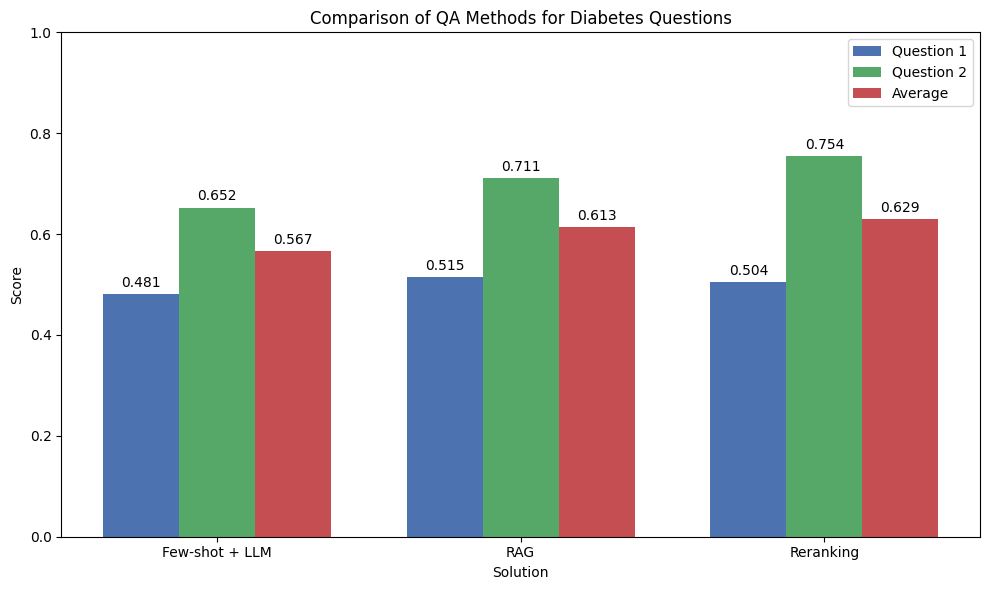

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ข้อมูล
solutions = ["Few-shot + LLM", "RAG", "Reranking"]
question_1 = [0.4808, 0.5154, 0.5045]
question_2 = [0.6525, 0.7111, 0.7545]
avg_score = [0.5666, 0.6132, 0.6295]

x = np.arange(len(solutions))  # ตำแหน่งแกน x
width = 0.25  # ความกว้างของ bar

# สร้างกราฟ
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width, question_1, width, label='Question 1', color='#4C72B0')
rects2 = ax.bar(x, question_2, width, label='Question 2', color='#55A868')
rects3 = ax.bar(x + width, avg_score, width, label='Average', color='#C44E52')

# เพิ่มชื่อแกนและ title
ax.set_ylabel('Score')
ax.set_xlabel('Solution')
ax.set_title('Comparison of QA Methods for Diabetes Questions')
ax.set_xticks(x)
ax.set_xticklabels(solutions)
ax.set_ylim(0, 1)
ax.legend()

# เพิ่มค่าตัวเลขบน bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),  # ขยับตัวเลขขึ้น 3 จุด
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

In [ ]:
test_set = [
    {
        "question": "ผู้ป่วยเบาหวานควรออกกำลังกายแบบแอโรบิกอย่างน้อยกี่นาทีต่อสัปดาห์?",
        "answer": "อย่างน้อย 150 นาทีต่อสัปดาห์ ของการออกกำลังกายแบบแอโรบิกความเข้มข้นปานกลาง เช่น การเดินเร็ว หรือประมาณ 30 นาทีต่อวัน 5 วันต่อสัปดาห์ (ตามคำแนะนำของ ADA) (End of response)",
        "source_authority": "American Diabetes Association (ADA) Guidelines"
    },
    {
        "question": "ภาวะน้ำตาลในเลือดต่ำ (Hypoglycemia) ตามมาตรฐานทางการแพทย์คือระดับน้ำตาลในเลือดต่ำกว่าเท่าไหร่?",
        "answer": "คือเมื่อระดับน้ำตาลในเลือดลดต่ำลงถึง 70 มิลลิกรัมต่อเดซิลิตร (mg/dL) หรือต่ำกว่า ผู้ป่วยควรรีบใช้ กฎ 15/15 ในการรักษา (End of response)",
        "source_authority": "American Diabetes Association (ADA)"
    },
    {
        "question": "อะไรคือสาเหตุหลักที่ทำให้ผู้ป่วยเบาหวานชนิดที่ 2 จำเป็นต้องฉีดอินซูลินในที่สุด?",
        "answer": "เป็นเพราะภาวะของโรคมีการดำเนินไปอย่างต่อเนื่อง ทำให้ β-cell (เบต้าเซลล์) ในตับอ่อน เสื่อมสภาพลงจนไม่สามารถผลิตอินซูลินได้เพียงพอต่อความต้องการของร่างกายเพื่อต่อต้านภาวะดื้ออินซูลิน (End of response)",
        "source_authority": "Clinical Practice Guidelines, National Health Service (NHS)"
    },
    {
        "question": "การมีระดับน้ำตาลในเลือดสูงเรื้อรัง (Hyperglycemia) สามารถนำไปสู่ภาวะแทรกซ้อนทางสายตาที่ร้ายแรงอะไรได้บ้าง?",
        "answer": "ภาวะแทรกซ้อนทางสายตาที่สำคัญที่สุดคือ โรคเบาหวานขึ้นจอตา (Diabetic Retinopathy) ซึ่งเกิดจากความเสียหายของหลอดเลือดขนาดเล็กที่จอตาและอาจนำไปสู่การสูญเสียการมองเห็นได้ (End of response)",
        "source_authority": "National Eye Institute (NEI) และ NIDDK (NIH)"
    },
    {
        "question": "ความแตกต่างหลักระหว่างโรคเบาหวานชนิดที่ 1 และชนิดที่ 2 คืออะไร?",
        "answer": "ชนิดที่ 1 คือภาวะที่ร่างกาย ขาดอินซูลินโดยสมบูรณ์ เนื่องจากระบบภูมิคุ้มกันทำลายเซลล์ตับอ่อน (Autoimmune) ส่วน ชนิดที่ 2 คือภาวะที่ร่างกาย ดื้อต่ออินซูลิน (Insulin Resistance) หรือผลิตอินซูลินได้ไม่เพียงพอ (End of response)",
        "source_authority": "Diabetes UK และ Mayo Clinic"
    }
]
# -------------------------
# 2) ใช้ RAG / Retrieval (Dense, Sparse หรือ Hybrid)
# -------------------------
generated_answers = []
for item in test_set:
    q = item["question"]
    # เรียก agent หรือ RAG pipeline ของคุณ
    gen_answer = rag_pipeline(q)   # <-- ตรงนี้คือฟังก์ชัน QA ของคุณ
    generated_answers.append(gen_answer)

# -------------------------
# 3) Evaluation ด้วย ROUGE
# -------------------------
from rouge_score import rouge_scorer

gold_answers = [item["answer"] for item in test_set]
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

for i, (gen, gold) in enumerate(zip(generated_answers, gold_answers)):
    print(f"Q{i+1}: {test_set[i]['question']}")
    scores = scorer.score(gold, gen)
    for metric, score in scores.items():
        print(f"  {metric}: precision={score.precision:.3f}, recall={score.recall:.3f}, fmeasure={score.fmeasure:.3f}")
    print("-"*50)

In [ ]:
!pip install -U langchain-community